In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


(8, 8)


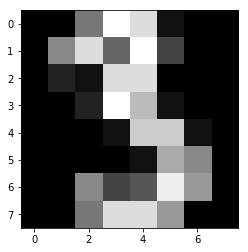

In [3]:
img = images[3]

print(img.shape)
assert 2 == len(img.shape)

plt.figure(1)
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

In [4]:
from sklearn import model_selection

X_all = data
Y_all = target

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.4, random_state=0)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1078, 64) (719, 64) (1078,) (719,)


In [5]:
def dist_loop(training, test):
    N = training.shape[0]
    M = test.shape[0]
    D = training.shape[1]
    #print(N, M, D)
    result = np.zeros((N, M))
    
    for n in range(N):
        for m in range(M):
            result[n, m] = np.linalg.norm(training[n] - test[m])
            
    return result
    

In [6]:
def dist_vec(training, test):
    return np.sqrt(np.square(training[:,np.newaxis] - test).sum(axis=2))


### alternative dist_vec
$$
\begin{align*}
    dist(A,B) &= \sqrt{\sum(A-B)^2}\\
        &= \sqrt{\sum A^2 -2\sum AB + \sum B^2}\qquad&&\text{pointwise multiplication}\\
        &= \sqrt{\sum A^2 - 2 A\cdot B + \sum B^2}\qquad&&\text{dot product}
\end{align*}
$$

In [7]:
def dist_vec_2(training, test):
    sums = np.sum(np.square(training)[:,np.newaxis,:], axis=2) - 2*training.dot(test.T) + np.sum(np.square(test), axis=1)
    return np.sqrt(sums)

In [47]:
from sklearn.metrics import pairwise_distances

%timeit distances_loop = dist_loop(X_train, X_test)
%timeit distances_vec = dist_vec(X_train, X_test)
%timeit distances_vec_2 = dist_vec_2(X_train, X_test)
%timeit distances_sklearn = pairwise_distances(X_train, X_test)

7.07 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
487 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.8 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.3 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
distances_loop = dist_loop(X_train, X_test)
distances_vec = dist_vec(X_train, X_test)
distances_vec_2 = dist_vec_2(X_train, X_test)
distances_sklearn = pairwise_distances(X_train, X_test)
print(np.array_equal(distances_loop, distances_vec))
print(np.array_equal(distances_loop, distances_vec_2))
print(np.array_equal(distances_loop, distances_sklearn))

True
True
True


In [12]:
def knn(training, training_labels, test, k):
    distance_matrix = dist_vec_2(training, test)
    k_min = np.argpartition(distance_matrix, k, axis=0)
    k_min = k_min[:k,:]
    
    classified = np.zeros(k_min.shape[1], dtype=np.uint8)
    for i in range(k_min.shape[1]):
        classified[i] = np.bincount(training_labels[k_min[:,i]]).argmax()
    
    return classified
    


In [13]:
def test_knn(X_train, Y_train, X_test, Y_test, k):
    classified = knn(X_train, Y_train, X_test, k)
    error = 0
    for index, label in enumerate(classified):
        if label != Y_test[index]:
            error += 1
    return error / len(classified)
    
X_train_39 = X_train[(Y_train == 3) | (Y_train == 9)]
Y_train_39 = Y_train[(Y_train == 3) | (Y_train == 9)]
X_test_39 = X_test[(Y_test == 3) | (Y_test == 9)]
Y_test_39 = Y_test[(Y_test == 3) | (Y_test == 9)]
    
#for k in [1,3,5,9,17,33]:
for k in range(1,34,2):
    #print(f"k = {k}:\t{test_knn(X_train,Y_train,X_test,Y_test,k)*100:0.2f}%")
    print(f"k = {k}:\t{test_knn(X_train_39,Y_train_39,X_test_39,Y_test_39,k)*100:0.2f}%")

k = 1:	1.39%
k = 3:	0.69%
k = 5:	0.69%
k = 7:	0.00%
k = 9:	0.69%
k = 11:	0.00%
k = 13:	0.00%
k = 15:	0.69%
k = 17:	0.69%
k = 19:	2.08%
k = 21:	2.08%
k = 23:	2.78%
k = 25:	2.08%
k = 27:	2.08%
k = 29:	2.08%
k = 31:	2.08%
k = 33:	2.08%


C:\Users\nwolf\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


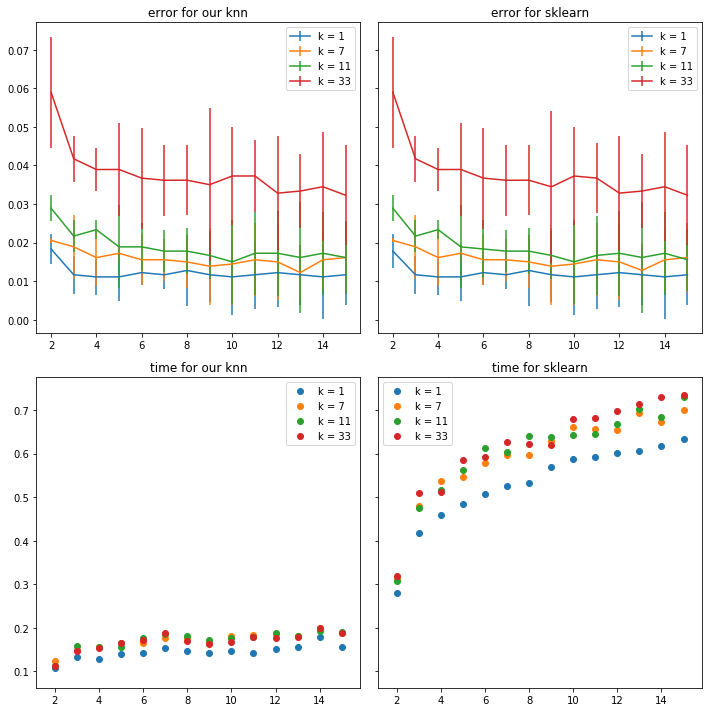

In [36]:
from sklearn.neighbors import KNeighborsClassifier
import time

def split_folds(data, target, L):
    permutation = np.random.permutation(len(data))
    data_permuted = data[permutation]
    target_permuted = target[permutation]
    return np.array(np.array_split(data_permuted, L)), np.array(np.array_split(target_permuted, L))
    
def cross_validation(data, target, L, k):
    X_folds, Y_folds = split_folds(data, target, L)
    
    
    errors = np.zeros(L)
    errors_skl = np.zeros(L)
    
    time_knn = time_skl = 0
    
    for l in range(L):
        X_l = X_folds[l]
        Y_l = Y_folds[l]
        mask = np.arange(len(X_folds)) != l
        X_rest = X_folds[np.arange(len(X_folds)) != l]
        Y_rest = Y_folds[np.arange(len(Y_folds)) != l]
        X_rest = np.concatenate(X_rest)
        Y_rest = np.concatenate(Y_rest)
        
        start = time.time()
        errors[l] = test_knn(X_rest, Y_rest, X_l, Y_l, k)
        time_knn += time.time() - start
        
        start = time.time()
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_rest, Y_rest)
        classified = neigh.predict(X_l)
        error = 0
        for index, label in enumerate(classified):
            if label != Y_l[index]:
                error += 1
        errors_skl[l] = error / len(classified)
        time_skl += time.time() - start
    
    return errors, errors_skl, time_knn, time_skl

"""
print("L = 2:")
cross_validation(data, target, 2)

print("\nL = 5:")
cross_validation(data, target, 5)

print("\nL = 10:")
cross_validation(data, target, 5)
"""

mean_knn = []
std_knn = []
mean_skl = []
std_skl = []
times_knn = []
times_skl = []

L_values = [i for i in range(2, 16)]
k_values = [1, 7, 11, 33]
for index, k in enumerate(k_values):
    mean_knn.append([])
    std_knn.append([])
    mean_skl.append([])
    std_skl.append([])
    times_knn.append([])
    times_skl.append([])
    for L in L_values:
        #print(L)
        errors_knn, errors_skl, time_knn, time_skl = cross_validation(data, target, L, k)
        mean_knn[index].append(np.mean(errors_knn))
        std_knn[index].append(np.std(errors_knn))
        mean_skl[index].append(np.mean(errors_skl))
        std_skl[index].append(np.std(errors_skl))
        times_knn[index].append(time_knn)
        times_skl[index].append(time_skl)
        #print(f"knn: ({np.mean(errors_knn)*100:0.2f} +- {np.std(errors_knn)*100:0.2f})%\ttime: {time_knn:3.2f}s")
        #print(f"skl: ({np.mean(errors_skl)*100:0.2f} +- {np.std(errors_skl)*100:0.2f})%\ttime: {time_skl:3.2f}s")
    
    
fig, axs = plt.subplots(2, 2, sharey='row', tight_layout=True, num=2, figsize=(10,10))
axs[0,0].title.set_text("error for our knn")
axs[0,1].title.set_text("error for sklearn")
axs[1,0].title.set_text("time for our knn")
axs[1,1].title.set_text("time for sklearn")

for index, k in enumerate(k_values):

    axs[0,0].errorbar(L_values, np.array(mean_knn[index]), yerr=np.array(std_knn[index]), label=f"k = {k}")
    axs[0,1].errorbar(L_values, np.array(mean_skl[index]), yerr=np.array(std_skl[index]), label=f"k = {k}")

    axs[1,0].scatter(L_values, np.array(times_knn[index]), label=f"k = {k}")
    axs[1,1].scatter(L_values, np.array(times_skl[index]), label=f"k = {k}")
    
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.show()